In [ ]:
#pip install --upgrade tf

In [ ]:
from numpy import array
from numpy import hstack
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
import os

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
#Returns array of values with True_data(available frames)
def Missing_Frames(data_info):
    True_Data = np.empty((0, 2), int)
    From = 0
    false_found = 0
    last_true0 = 0
    last_true1 = 0
    for index, row in data_info.iterrows():
        #print(row['Mocap_Data_Exist'])
        if(row['Video_Data_Exist'] == False):
            if(false_found == 0):
                True_Data = np.append(True_Data, np.array([[From, index-1]]), axis=0)
            false_found = 1
            From = index+1
            last_true0 = index
        else:
            false_found = 0
            last_true1 = index
    True_Data = np.append(True_Data, np.array([[last_true0+1, last_true1]]), axis=0)
    return True_Data

def LSTM_Model(X,y,n_steps,n_features):
    #model definition and fit
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=400, verbose=0)

In [ ]:
#Timeseries Prediction Function
def PredictTimeSeries(x_input,n_times,n_steps,n_features):
    # demonstrate prediction for next 10 days
    #x_input = array([[ -54,1618,65,-35,1528,-20,-147,1536,83],
     #                [-55,1617,63,-36,1526,-21,147,1535,82], 
      #               [-55,1617,62,-36,1525,-22,148,1535,81], 
       #              [-55,1617,61,-36,1535,-22,-148,1535,80]])

    temp_input=list(x_input)
    lst_output=[]
    i=0
    while(i<n_times):
        #this length is same as steps
        if(len(temp_input)>n_steps):
            #print("temp input 3 ",  temp_input)
            x_input=array(temp_input[1:])
            #print("temp input 4 ",  x_input)
            #print("{} day input {}".format(i,x_input))
            #print(x_input)
            x_input = x_input.reshape((1, n_steps, n_features))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            #print("{} day output {}".format(i,yhat))
            temp_input.append(yhat[0])
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.append(yhat[0])
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            #print("temp input 1 ",  temp_input)
            temp_input.append(yhat[0])
            #print("temp input 2 ",  temp_input)
            lst_output.append(yhat[0])
            i=i+1
    return lst_output

In [ ]:
#Get list of info csv form directory
def fn_getfilenames(dir): 
    return os.listdir(dir)

#dirVideoCap="data-csv"
#dirInfo = "data"
#dirVideoCap="data-csv-test"
#dirInfo = "data-test"

dirVideoCap="data-csv"
dirInfo = "data"
file_list = fn_getfilenames(dirInfo)
infofile_list = []
for file in file_list:
    if "_info.csv" in file:
        infofile_list.append(file)
infofile_list.sort()
infofile_list

In [ ]:
# choose a number of time steps for Time Series
n_steps = 10

In [ ]:
#CSV Pixel - Prediction
print("Total files to process: " + str(len(infofile_list)))
predicted_all = pd.DataFrame() #to store the predicted datavalues
file_count=1

#for all Files
for file in infofile_list:
    #missing frames dataset with True/False
    data_info = pd.read_csv(dirInfo + "/" + file)
    #print(dirInfo + "/" + file)
    TrueFalse_Data = Missing_Frames(data_info)
      
    VideoCap_file = file.replace("_info.csv", ".csv")
    #print("\nProcessing file : " + VideoCap_file + " ...")
    print("\n" + str(file_count) + ".Processing file : " + VideoCap_file + " ...")
    print("Missing frame(True) summary of this file")
    print(TrueFalse_Data)
  
    #print(dirVideoCap + "/" + VideoCap_file)
    data = pd.read_csv(dirVideoCap + "/" + VideoCap_file)
    data = data.iloc[:,11:]
    #print(data.head(1))
    #print(list(data.columns))
    dataset = data.to_numpy()
    #print(dataset)
    rowIndex=0
    #True_Frame = data.iloc[TrueFalse_Data[0][0]:TrueFalse_Data[rowIndex][1]+1,]
    #if 3 entries in TrueFalse_Data, only 2 missing sections
    print("There are " + str(len(TrueFalse_Data)-1) +  " missing frames in the file")
    #print(len(TrueFalse_Data))
    while(rowIndex < len(TrueFalse_Data)-1):
        #print(TrueFalse_Data[rowIndex][0])
        #print(TrueFalse_Data[rowIndex][1])
        
        True_Frame = data.iloc[TrueFalse_Data[rowIndex][0]:TrueFalse_Data[rowIndex][1]+1,]
        #True_Frame_Head = data.iloc[TrueFalse_Data[rowIndex][0]:TrueFalse_Data[rowIndex][1]+1,]
        
        #print(True_Frame)
        #if(rowIndex > 0 ):
        #    True_Frame = pd.concat([predicted_df,True_Frame], ignore_index=True)
        #Convert to Array
        dataset = True_Frame.to_numpy()
        #print(dataset)
        
        # convert into input/output
        X, y = split_sequences(dataset, n_steps)
        #print(X.shape, y.shape)
        
        #RNN - LSTM
        print("Training LSTM Model ...")
        # the dataset knows the number of features, e.g. 2
        n_features = X.shape[2]
        # define and fit model
        #LSTM_Model(X,y,n_steps,n_features)
        
        model = Sequential()
        model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
        model.add(LSTM(100, activation='relu'))
        model.add(Dense(n_features))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        #model.fit(X, y, epochs=400, verbose=0)
        model.fit(X, y, epochs=50, verbose=0)
        
        # demonstrate prediction
        x_input = X[len(X)-1]
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        #print("Model output for an input...")
        #print(yhat)
        
        print("Predicting Missing frame " + str(rowIndex+1) + " ...")
        #Prediction 
        #print(TrueFalse_Data[rowIndex][1]+1)
        #print(TrueFalse_Data[rowIndex+1][0]-1)
        MissingFramesCount = (TrueFalse_Data[rowIndex+1][0]-1) - (TrueFalse_Data[rowIndex][1])
        lst_output = PredictTimeSeries(x_input,MissingFramesCount,n_steps,n_features)
        #print(round(pd.DataFrame(lst_output)))
        predicted_df = round(pd.DataFrame(lst_output))
        #print(predicted_df)
        #predicted_df.set_axis(['HeadTop_X', 'HeadTop_Y', 'HeadTop_Z', 'HeadFront_X', 'HeadFront_Y','HeadFront_Z','HeadSide_X','HeadSide_Y','HeadSide_Z'], axis='columns', inplace=True)
        predicted_df.set_axis(data.columns, axis='columns', inplace=True)
        #print(predicted_df)
        predicted_all = pd.concat([predicted_all, predicted_df], ignore_index=True)
        #if(rowIndex == 0):
        #    True_Plus_Predicted_Frame = pd.concat([True_Frame, predicted_df], ignore_index=True)
        #else:
        #    True_Plus_Predicted_Frame = pd.concat([True_Plus_Predicted_Frame, True_Frame, predicted_df], ignore_index=True)


        print("Missing frame " + str(rowIndex+1) + " completed.\n")
        rowIndex=rowIndex+1
    #file_name = "FD_Pred/" + file.replace("_info.csv", "_pred_video.csv")
    #predicted_all.to_csv(file_name,index=False)
    file_count = file_count + 1
    print(predicted_all.shape)
#file_name = "FD_Pred/" + file.replace("_info.csv", "_pred_video.csv")
file_name = "Pred/bbdc_pred_video.csv" 

#if pixel goes above 255 in timeseries prediction, replace with all >255 values with 255
predicted_all[predicted_all>255] = 255
#if pixel goes below zero(-), replace with all < 0 values with 0
predicted_all[predicted_all < 0] = 0

predicted_all.to_csv(file_name,index=False)
print(predicted_all.shape)

print("\nAll files are Completed")

### Convert Pixel to Image

In [18]:
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
#dfpred = pd.read_csv("Pred/s049t01_pred_video.csv")
dfpred = pd.read_csv("Pred/bbdc_pred_video.csv")

20985
0
(15360,)
1
(15360,)
2
(15360,)
3
(15360,)
4
(15360,)
5
(15360,)
6
(15360,)
7
(15360,)
8
(15360,)
9
(15360,)
10
(15360,)
11
(15360,)
12
(15360,)
13
(15360,)
14
(15360,)
15
(15360,)
16
(15360,)
17
(15360,)
18
(15360,)
19
(15360,)
20
(15360,)
21
(15360,)
22
(15360,)
23
(15360,)
24
(15360,)
25
(15360,)
26
(15360,)
27
(15360,)
28
(15360,)
29
(15360,)
30
(15360,)
31
(15360,)
32
(15360,)
33
(15360,)
34
(15360,)
35
(15360,)
36
(15360,)
37
(15360,)
38
(15360,)
39
(15360,)
40
(15360,)
41
(15360,)
42
(15360,)
43
(15360,)
44
(15360,)
45
(15360,)
46
(15360,)
47
(15360,)
48
(15360,)
49
(15360,)
50
(15360,)
51
(15360,)
52
(15360,)
53
(15360,)
54
(15360,)
55
(15360,)
56
(15360,)
57
(15360,)
58
(15360,)
59
(15360,)
60
(15360,)
61
(15360,)
62
(15360,)
63
(15360,)
64
(15360,)
65
(15360,)
66
(15360,)
67
(15360,)
68
(15360,)
69
(15360,)
70
(15360,)
71
(15360,)
72
(15360,)
73
(15360,)
74
(15360,)
75
(15360,)
76
(15360,)
77
(15360,)
78
(15360,)
79
(15360,)
80
(15360,)
81
(15360,)
82
(15360,)
83
(1536

639
(15360,)
640
(15360,)
641
(15360,)
642
(15360,)
643
(15360,)
644
(15360,)
645
(15360,)
646
(15360,)
647
(15360,)
648
(15360,)
649
(15360,)
650
(15360,)
651
(15360,)
652
(15360,)
653
(15360,)
654
(15360,)
655
(15360,)
656
(15360,)
657
(15360,)
658
(15360,)
659
(15360,)
660
(15360,)
661
(15360,)
662
(15360,)
663
(15360,)
664
(15360,)
665
(15360,)
666
(15360,)
667
(15360,)
668
(15360,)
669
(15360,)
670
(15360,)
671
(15360,)
672
(15360,)
673
(15360,)
674
(15360,)
675
(15360,)
676
(15360,)
677
(15360,)
678
(15360,)
679
(15360,)
680
(15360,)
681
(15360,)
682
(15360,)
683
(15360,)
684
(15360,)
685
(15360,)
686
(15360,)
687
(15360,)
688
(15360,)
689
(15360,)
690
(15360,)
691
(15360,)
692
(15360,)
693
(15360,)
694
(15360,)
695
(15360,)
696
(15360,)
697
(15360,)
698
(15360,)
699
(15360,)
700
(15360,)
701
(15360,)
702
(15360,)
703
(15360,)
704
(15360,)
705
(15360,)
706
(15360,)
707
(15360,)
708
(15360,)
709
(15360,)
710
(15360,)
711
(15360,)
712
(15360,)
713
(15360,)
714
(15360,)
715
(15360,)

1250
(15360,)
1251
(15360,)
1252
(15360,)
1253
(15360,)
1254
(15360,)
1255
(15360,)
1256
(15360,)
1257
(15360,)
1258
(15360,)
1259
(15360,)
1260
(15360,)
1261
(15360,)
1262
(15360,)
1263
(15360,)
1264
(15360,)
1265
(15360,)
1266
(15360,)
1267
(15360,)
1268
(15360,)
1269
(15360,)
1270
(15360,)
1271
(15360,)
1272
(15360,)
1273
(15360,)
1274
(15360,)
1275
(15360,)
1276
(15360,)
1277
(15360,)
1278
(15360,)
1279
(15360,)
1280
(15360,)
1281
(15360,)
1282
(15360,)
1283
(15360,)
1284
(15360,)
1285
(15360,)
1286
(15360,)
1287
(15360,)
1288
(15360,)
1289
(15360,)
1290
(15360,)
1291
(15360,)
1292
(15360,)
1293
(15360,)
1294
(15360,)
1295
(15360,)
1296
(15360,)
1297
(15360,)
1298
(15360,)
1299
(15360,)
1300
(15360,)
1301
(15360,)
1302
(15360,)
1303
(15360,)
1304
(15360,)
1305
(15360,)
1306
(15360,)
1307
(15360,)
1308
(15360,)
1309
(15360,)
1310
(15360,)
1311
(15360,)
1312
(15360,)
1313
(15360,)
1314
(15360,)
1315
(15360,)
1316
(15360,)
1317
(15360,)
1318
(15360,)
1319
(15360,)
1320
(15360,)
1321
(

1836
(15360,)
1837
(15360,)
1838
(15360,)
1839
(15360,)
1840
(15360,)
1841
(15360,)
1842
(15360,)
1843
(15360,)
1844
(15360,)
1845
(15360,)
1846
(15360,)
1847
(15360,)
1848
(15360,)
1849
(15360,)
1850
(15360,)
1851
(15360,)
1852
(15360,)
1853
(15360,)
1854
(15360,)
1855
(15360,)
1856
(15360,)
1857
(15360,)
1858
(15360,)
1859
(15360,)
1860
(15360,)
1861
(15360,)
1862
(15360,)
1863
(15360,)
1864
(15360,)
1865
(15360,)
1866
(15360,)
1867
(15360,)
1868
(15360,)
1869
(15360,)
1870
(15360,)
1871
(15360,)
1872
(15360,)
1873
(15360,)
1874
(15360,)
1875
(15360,)
1876
(15360,)
1877
(15360,)
1878
(15360,)
1879
(15360,)
1880
(15360,)
1881
(15360,)
1882
(15360,)
1883
(15360,)
1884
(15360,)
1885
(15360,)
1886
(15360,)
1887
(15360,)
1888
(15360,)
1889
(15360,)
1890
(15360,)
1891
(15360,)
1892
(15360,)
1893
(15360,)
1894
(15360,)
1895
(15360,)
1896
(15360,)
1897
(15360,)
1898
(15360,)
1899
(15360,)
1900
(15360,)
1901
(15360,)
1902
(15360,)
1903
(15360,)
1904
(15360,)
1905
(15360,)
1906
(15360,)
1907
(

2422
(15360,)
2423
(15360,)
2424
(15360,)
2425
(15360,)
2426
(15360,)
2427
(15360,)
2428
(15360,)
2429
(15360,)
2430
(15360,)
2431
(15360,)
2432
(15360,)
2433
(15360,)
2434
(15360,)
2435
(15360,)
2436
(15360,)
2437
(15360,)
2438
(15360,)
2439
(15360,)
2440
(15360,)
2441
(15360,)
2442
(15360,)
2443
(15360,)
2444
(15360,)
2445
(15360,)
2446
(15360,)
2447
(15360,)
2448
(15360,)
2449
(15360,)
2450
(15360,)
2451
(15360,)
2452
(15360,)
2453
(15360,)
2454
(15360,)
2455
(15360,)
2456
(15360,)
2457
(15360,)
2458
(15360,)
2459
(15360,)
2460
(15360,)
2461
(15360,)
2462
(15360,)
2463
(15360,)
2464
(15360,)
2465
(15360,)
2466
(15360,)
2467
(15360,)
2468
(15360,)
2469
(15360,)
2470
(15360,)
2471
(15360,)
2472
(15360,)
2473
(15360,)
2474
(15360,)
2475
(15360,)
2476
(15360,)
2477
(15360,)
2478
(15360,)
2479
(15360,)
2480
(15360,)
2481
(15360,)
2482
(15360,)
2483
(15360,)
2484
(15360,)
2485
(15360,)
2486
(15360,)
2487
(15360,)
2488
(15360,)
2489
(15360,)
2490
(15360,)
2491
(15360,)
2492
(15360,)
2493
(

3008
(15360,)
3009
(15360,)
3010
(15360,)
3011
(15360,)
3012
(15360,)
3013
(15360,)
3014
(15360,)
3015
(15360,)
3016
(15360,)
3017
(15360,)
3018
(15360,)
3019
(15360,)
3020
(15360,)
3021
(15360,)
3022
(15360,)
3023
(15360,)
3024
(15360,)
3025
(15360,)
3026
(15360,)
3027
(15360,)
3028
(15360,)
3029
(15360,)
3030
(15360,)
3031
(15360,)
3032
(15360,)
3033
(15360,)
3034
(15360,)
3035
(15360,)
3036
(15360,)
3037
(15360,)
3038
(15360,)
3039
(15360,)
3040
(15360,)
3041
(15360,)
3042
(15360,)
3043
(15360,)
3044
(15360,)
3045
(15360,)
3046
(15360,)
3047
(15360,)
3048
(15360,)
3049
(15360,)
3050
(15360,)
3051
(15360,)
3052
(15360,)
3053
(15360,)
3054
(15360,)
3055
(15360,)
3056
(15360,)
3057
(15360,)
3058
(15360,)
3059
(15360,)
3060
(15360,)
3061
(15360,)
3062
(15360,)
3063
(15360,)
3064
(15360,)
3065
(15360,)
3066
(15360,)
3067
(15360,)
3068
(15360,)
3069
(15360,)
3070
(15360,)
3071
(15360,)
3072
(15360,)
3073
(15360,)
3074
(15360,)
3075
(15360,)
3076
(15360,)
3077
(15360,)
3078
(15360,)
3079
(

3594
(15360,)
3595
(15360,)
3596
(15360,)
3597
(15360,)
3598
(15360,)
3599
(15360,)
3600
(15360,)
3601
(15360,)
3602
(15360,)
3603
(15360,)
3604
(15360,)
3605
(15360,)
3606
(15360,)
3607
(15360,)
3608
(15360,)
3609
(15360,)
3610
(15360,)
3611
(15360,)
3612
(15360,)
3613
(15360,)
3614
(15360,)
3615
(15360,)
3616
(15360,)
3617
(15360,)
3618
(15360,)
3619
(15360,)
3620
(15360,)
3621
(15360,)
3622
(15360,)
3623
(15360,)
3624
(15360,)
3625
(15360,)
3626
(15360,)
3627
(15360,)
3628
(15360,)
3629
(15360,)
3630
(15360,)
3631
(15360,)
3632
(15360,)
3633
(15360,)
3634
(15360,)
3635
(15360,)
3636
(15360,)
3637
(15360,)
3638
(15360,)
3639
(15360,)
3640
(15360,)
3641
(15360,)
3642
(15360,)
3643
(15360,)
3644
(15360,)
3645
(15360,)
3646
(15360,)
3647
(15360,)
3648
(15360,)
3649
(15360,)
3650
(15360,)
3651
(15360,)
3652
(15360,)
3653
(15360,)
3654
(15360,)
3655
(15360,)
3656
(15360,)
3657
(15360,)
3658
(15360,)
3659
(15360,)
3660
(15360,)
3661
(15360,)
3662
(15360,)
3663
(15360,)
3664
(15360,)
3665
(

4180
(15360,)
4181
(15360,)
4182
(15360,)
4183
(15360,)
4184
(15360,)
4185
(15360,)
4186
(15360,)
4187
(15360,)
4188
(15360,)
4189
(15360,)
4190
(15360,)
4191
(15360,)
4192
(15360,)
4193
(15360,)
4194
(15360,)
4195
(15360,)
4196
(15360,)
4197
(15360,)
4198
(15360,)
4199
(15360,)
4200
(15360,)
4201
(15360,)
4202
(15360,)
4203
(15360,)
4204
(15360,)
4205
(15360,)
4206
(15360,)
4207
(15360,)
4208
(15360,)
4209
(15360,)
4210
(15360,)
4211
(15360,)
4212
(15360,)
4213
(15360,)
4214
(15360,)
4215
(15360,)
4216
(15360,)
4217
(15360,)
4218
(15360,)
4219
(15360,)
4220
(15360,)
4221
(15360,)
4222
(15360,)
4223
(15360,)
4224
(15360,)
4225
(15360,)
4226
(15360,)
4227
(15360,)
4228
(15360,)
4229
(15360,)
4230
(15360,)
4231
(15360,)
4232
(15360,)
4233
(15360,)
4234
(15360,)
4235
(15360,)
4236
(15360,)
4237
(15360,)
4238
(15360,)
4239
(15360,)
4240
(15360,)
4241
(15360,)
4242
(15360,)
4243
(15360,)
4244
(15360,)
4245
(15360,)
4246
(15360,)
4247
(15360,)
4248
(15360,)
4249
(15360,)
4250
(15360,)
4251
(

4766
(15360,)
4767
(15360,)
4768
(15360,)
4769
(15360,)
4770
(15360,)
4771
(15360,)
4772
(15360,)
4773
(15360,)
4774
(15360,)
4775
(15360,)
4776
(15360,)
4777
(15360,)
4778
(15360,)
4779
(15360,)
4780
(15360,)
4781
(15360,)
4782
(15360,)
4783
(15360,)
4784
(15360,)
4785
(15360,)
4786
(15360,)
4787
(15360,)
4788
(15360,)
4789
(15360,)
4790
(15360,)
4791
(15360,)
4792
(15360,)
4793
(15360,)
4794
(15360,)
4795
(15360,)
4796
(15360,)
4797
(15360,)
4798
(15360,)
4799
(15360,)
4800
(15360,)
4801
(15360,)
4802
(15360,)
4803
(15360,)
4804
(15360,)
4805
(15360,)
4806
(15360,)
4807
(15360,)
4808
(15360,)
4809
(15360,)
4810
(15360,)
4811
(15360,)
4812
(15360,)
4813
(15360,)
4814
(15360,)
4815
(15360,)
4816
(15360,)
4817
(15360,)
4818
(15360,)
4819
(15360,)
4820
(15360,)
4821
(15360,)
4822
(15360,)
4823
(15360,)
4824
(15360,)
4825
(15360,)
4826
(15360,)
4827
(15360,)
4828
(15360,)
4829
(15360,)
4830
(15360,)
4831
(15360,)
4832
(15360,)
4833
(15360,)
4834
(15360,)
4835
(15360,)
4836
(15360,)
4837
(

5352
(15360,)
5353
(15360,)
5354
(15360,)
5355
(15360,)
5356
(15360,)
5357
(15360,)
5358
(15360,)
5359
(15360,)
5360
(15360,)
5361
(15360,)
5362
(15360,)
5363
(15360,)
5364
(15360,)
5365
(15360,)
5366
(15360,)
5367
(15360,)
5368
(15360,)
5369
(15360,)
5370
(15360,)
5371
(15360,)
5372
(15360,)
5373
(15360,)
5374
(15360,)
5375
(15360,)
5376
(15360,)
5377
(15360,)
5378
(15360,)
5379
(15360,)
5380
(15360,)
5381
(15360,)
5382
(15360,)
5383
(15360,)
5384
(15360,)
5385
(15360,)
5386
(15360,)
5387
(15360,)
5388
(15360,)
5389
(15360,)
5390
(15360,)
5391
(15360,)
5392
(15360,)
5393
(15360,)
5394
(15360,)
5395
(15360,)
5396
(15360,)
5397
(15360,)
5398
(15360,)
5399
(15360,)
5400
(15360,)
5401
(15360,)
5402
(15360,)
5403
(15360,)
5404
(15360,)
5405
(15360,)
5406
(15360,)
5407
(15360,)
5408
(15360,)
5409
(15360,)
5410
(15360,)
5411
(15360,)
5412
(15360,)
5413
(15360,)
5414
(15360,)
5415
(15360,)
5416
(15360,)
5417
(15360,)
5418
(15360,)
5419
(15360,)
5420
(15360,)
5421
(15360,)
5422
(15360,)
5423
(

KeyboardInterrupt: 

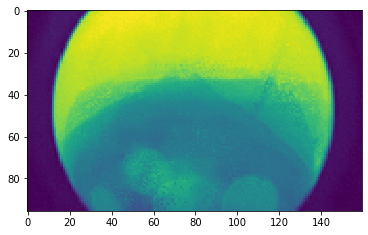

In [19]:
rowIndex=0
print(len(dfpred))
while (rowIndex < len(dfpred)):
#while (rowIndex < 2):
    df = dfpred.loc[rowIndex]
    print(rowIndex)
    print(df.shape)
    lst = df.to_numpy() 
    #print(lst.shape)
    array = np.array(lst, dtype=np.uint8)
    #print(array.shape)

    #new_image = Image.fromarray(array)
    #new_image.save('new4.png')
    imgname = "img"+str(rowIndex)
    imgname = Image.fromarray(array.reshape(96,160)) 
    #print(imgname)
    plt.imshow(imgname, interpolation='nearest')
    #img =  str(rowIndex) + str(".jpg")
    img =  str("Images/") + str(rowIndex) + str(".jpg")
    plt.savefig(img,format="jpg")
    #plt.plot(plt)
    rowIndex = rowIndex+1
    #print(plt.show)

In [ ]:
pip install opencv-python

### Convert Image to Video

In [16]:
import cv2
import numpy as np
import os
from os.path import isfile, join

ModuleNotFoundError: No module named 'cv2'

In [ ]:
#Get list of info csv form directory
def fn_getimagenames(dir): 
    return os.listdir(dir)

#dirVideoCap="data-csv-test"
#dirInfo = "data_test"
#file_list = fn_getfilenames(dirInfo)
#infofile_list = []
#for file in file_list:
    #if "_info.csv" in file:
        #infofile_list.append(file)
#infofile_list

In [ ]:
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    #files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files = fn_getimagenames(pathIn)
    files.remove(".DS_Store")
    #for sorting the file names properly
    files.sort()#key = lambda x: int(x[5:-4]))
    
    print(files)
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        print(filename)
        print(img)
        height, width, layers = img.shape
        size = (width,height)
        #print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
def main():
    pathIn= 'Images/'
    pathOut = 'video.mp4'
    #fps = 25.0
    fps = 30
    convert_frames_to_video(pathIn, pathOut, fps)
if __name__=="__main__":
    main()